### https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9762926

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd

import settings as s
from common import get_weights
from communities import get_communities_spark
from features import generate_features_spark, generate_features_udf_wrapper, SCHEMA_FEAT_UDF

%load_ext autoreload
%autoreload 2

In [2]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [3]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/29 00:34:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/29 00:34:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
data = pd.read_csv("./data/Libra_bank_3months_graph/data.csv")
rename = {
    "id_source": "source",
    "id_destination": "target",
    "cum_amount": "amount",
    "nr_transactions": "num_transactions",
    "nr_alerts": "alerts_count",
    "nr_reports": "reports_count",
}

data = data.rename(columns=rename)
data.loc[:, "source_"] = (
    data.loc[:, "source"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
data.loc[:, "target_"] = (
    data.loc[:, "target"].astype(str).apply(lambda x: f"nid-{int(x)}")
)
del data["source"]
del data["target"]
data = data.rename(
    columns={
        "source_": "source",
        "target_": "target",
    }
).loc[:, ["source", "target", "amount", "num_transactions", "alerts_count", "reports_count"]]

In [5]:
nodes_data = pd.DataFrame(index=sorted(set(data["source"].tolist() + data["target"].tolist())))
nodes_data.index.name = "key"

w_alerts = int(data["alerts_count"].sum() * 2)
w_reports = int(data["reports_count"].sum() * 2)

w_alerts_source = data[data["alerts_count"] > 0].groupby("source").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]
w_alerts_target = data[data["alerts_count"] > 0].groupby("target").agg({"alerts_count": "sum"}).to_dict()["alerts_count"]

w_reports_source = data[data["reports_count"] > 0].groupby("source").agg({"reports_count": "sum"}).to_dict()["reports_count"]
w_reports_target = data[data["reports_count"] > 0].groupby("target").agg({"reports_count": "sum"}).to_dict()["reports_count"]

nodes_data.loc[:, "alert_weight"] = nodes_data.index.map(
    lambda x: (w_alerts_source.get(x, 0) + w_alerts_target.get(x, 0)) / w_alerts
)
nodes_data.loc[:, "report_weight"] = nodes_data.index.map(
    lambda x: (w_reports_source.get(x, 0) + w_reports_target.get(x, 0)) / w_reports
)
alerted_nodes = set(nodes_data[nodes_data["alert_weight"] > 0].index)

In [6]:
total_nodes = nodes_data.shape[0]
perc_point_1_cnt = round(total_nodes * (0.1 / 100))
perc_point_2_cnt = round(total_nodes * (0.2 / 100))
perc_point_5_cnt = round(total_nodes * (0.5 / 100))
perc_1_cnt = round(total_nodes * (1 / 100))
perc_10_cnt = round(total_nodes * (10 / 100))
perc_20_cnt = round(total_nodes * (20 / 100))
perc_30_cnt = round(total_nodes * (30 / 100))
perc_40_cnt = round(total_nodes * (40 / 100))
perc_50_cnt = round(total_nodes * (50 / 100))
perc_75_cnt = round(total_nodes * (75 / 100))
print(total_nodes, perc_point_1_cnt, perc_point_2_cnt, perc_point_5_cnt, perc_1_cnt)

385100 385 770 1926 3851


In [7]:
graph_global = ig.Graph.DataFrame(data[["source", "target"]], use_vids=False, directed=True)

In [8]:
%%time

communities_egonet_red = []
for node in [x["name"] for x in graph_global.vs()]:
    neighborhood = graph_global.neighborhood(node, order=1, mode="all", mindist=0)
    sub_g = graph_global.induced_subgraph(neighborhood)
    names = [x["name"] for x in sub_g.vs()]
    communities_egonet_red.append((node, {x for x, y in zip(names, sub_g.degree(mode="all")) if y > 1} | {node}))
sizes_egonet_red = [len(x[1]) for x in communities_egonet_red]
sizes_egonet_red_alerted = [len(x[1]) for x in communities_egonet_red if alerted_nodes.intersection({x[0]})]

CPU times: user 20.6 s, sys: 11.5 s, total: 32.2 s
Wall time: 32.2 s


In [9]:
%%time

candidates = nodes_data.index.tolist()
data_in_scope = data.copy(deep=True)
data_in_scope = data_in_scope.set_index(["source", "target"]).join(
    get_weights(data_in_scope).set_index(["source", "target"]), how="left"
).reset_index()
data_in_scope.loc[:, "amount_weighted"] = (
    data_in_scope.loc[:, "amount"] * 
    (data_in_scope.loc[:, "weight"] / data_in_scope.loc[:, "weight"].max())
)

%run model.ipynb

anomalies_main = anomalies.copy(deep=True)

25/07/27 17:09:20 WARN TaskSetManager: Stage 0 contains a task of very large size (3851 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 472,592 | 213,511
Processed hop #2 | 6,730,058 | 194,847
Processed hop #3 | 7,805,533 | 186,398
Processed hop #4 | 8,894,931 | 185,538
Processed hop #5 | 8,889,368 | 185,321

Processing comm_as_target

Processed hop #1 | 414,376 | 221,458
Processed hop #2 | 6,111,806 | 201,104
Processed hop #3 | 7,163,788 | 188,404
Processed hop #4 | 8,469,276 | 186,909
Processed hop #5 | 8,208,835 | 183,360

Processing comm_as_passthrough

Processed hop #1 | 251,417 | 49,869
Processed hop #2 | 1,310,227 | 42,290
Processed hop #3 | 1,725,981 | 40,671
Processed hop #4 | 1,918,895 | 40,412
Processed hop #5 | 1,952,010 | 40,363

Processing comm_as_passthrough_reverse

Processed hop #1 | 197,559 | 49,869
Processed hop #2 | 1,081,845 | 41,267
Processed hop #3 | 1,434,805 | 38,874
Processed hop #4 | 1,719,403 | 38,462
Processed hop #5 | 1,722,034 | 38,030


comm_as_source_features

CPU times: user 32.1 s, sys: 356 ms, total: 32.4 s
Wall time: 32.5 s

comm_as_tar

CPU times: user 1.72 s, sys: 83.6 ms, total: 1.8 s
Wall time: 25.9 s
Leiden communitites features creation


CPU times: user 5.02 s, sys: 515 ms, total: 5.53 s
Wall time: 38.6 s
1-hop communitites features creation


CPU times: user 2min 14s, sys: 23.5 s, total: 2min 38s
Wall time: 5min 25s
1-hop-source features creation


25/07/27 17:28:17 WARN TaskSetManager: Stage 12 contains a task of very large size (6867 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.67 s, sys: 240 ms, total: 1.91 s
Wall time: 1min 15s
1-hop-target features creation


25/07/27 17:29:32 WARN TaskSetManager: Stage 15 contains a task of very large size (6961 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.71 s, sys: 212 ms, total: 1.92 s
Wall time: 1min 18s
Features: (385100, 176)
Deleted 10 constant columns
Script executed in 0:21:38
Training the model
CPU times: user 11min 11s, sys: 50.5 s, total: 12min 1s
Wall time: 12min 3s
CPU times: user 25min 29s, sys: 1min 53s, total: 27min 23s
Wall time: 33min 45s


In [10]:
def add_predicted_alert_weight(anomalies_input, perc_count_in):
    anomalies_perc_x = anomalies_input.copy(deep=True)
    index = anomalies_perc_x.head(perc_count_in).index.tolist()
    anomalies_perc_x = anomalies_perc_x.loc[index, :]
    anomalies_perc_x.loc[:, "predicted_alert_weight"] = anomalies_perc_x.loc[:, "alert_weight"]
    anomalies_perc_x.loc[:, "predicted_report_weight"] = anomalies_perc_x.loc[:, "report_weight"]
    return anomalies_perc_x

In [11]:
communities_1_hop_dict = dict(communities_1_hop)

comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_1_cnt).index]
comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_2_cnt).index]
comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_point_5_cnt).index]
comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies_main, perc_1_cnt).index]

sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]

sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

tpr = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"]).values
tpr_report = np.cumsum(add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"]).values

results = [{
    "rectify_perc": 1.0,
    "sizes_egonet_red_alerted": sizes_egonet_red_alerted,
    "sizes_1_hop_alerted": sizes_1_hop_alerted,
    "leiden_size_max": np.max(sizes_leiden),
    "leiden_size_mean": np.mean(sizes_leiden),
    "leiden_size_median": np.median(sizes_leiden),
    "1_hop_size_max": np.max(sizes_1_hop),
    "1_hop_size_mean": np.mean(sizes_1_hop),
    "1_hop_size_median": np.median(sizes_1_hop),
    "0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_alert_weight"].sum(),
    "0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_alert_weight"].sum(),
    "0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_alert_weight"].sum(),
    "1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_alert_weight"].sum(),
    "tpr_1%": tpr,
    "tpr_auc_1%": np.mean(tpr),
    "report_0.1%": add_predicted_alert_weight(anomalies_main, perc_point_1_cnt)["predicted_report_weight"].sum(),
    "report_0.2%": add_predicted_alert_weight(anomalies_main, perc_point_2_cnt)["predicted_report_weight"].sum(),
    "report_0.5%": add_predicted_alert_weight(anomalies_main, perc_point_5_cnt)["predicted_report_weight"].sum(),
    "report_1%": add_predicted_alert_weight(anomalies_main, perc_1_cnt)["predicted_report_weight"].sum(),
    "tpr_report_1%": tpr_report,
    "tpr_report_auc_1%": np.mean(tpr_report),
    "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
    "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
    "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
    "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
    "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
    "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
    "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
    "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
    "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
    "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
    "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
    "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
    "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
    "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
    "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
    "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
    "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
    "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
    "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
    "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
    "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
    "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
    "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
    "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
}]

In [12]:
%%time

for perc_count in [perc_75_cnt, perc_50_cnt, perc_40_cnt, perc_30_cnt, perc_20_cnt, perc_10_cnt]:
    rectify_perc = round(perc_count / total_nodes, 2)
    candidates = add_predicted_alert_weight(anomalies_main, perc_count).index.tolist()
    filter_ = data["source"].isin(candidates) & data["target"].isin(candidates)
    data_in_scope = data.loc[filter_, :]
    candidates = sorted(set(data_in_scope["source"].unique()).union(data_in_scope["target"].unique()))
    print("=" * 100)
    print(rectify_perc, perc_count, len(candidates), data_in_scope.shape)
    print("=" * 100)
    data_in_scope = data_in_scope.set_index(["source", "target"]).join(
        get_weights(data_in_scope).set_index(["source", "target"]), how="left"
    ).reset_index()
    data_in_scope.loc[:, "amount_weighted"] = data_in_scope.loc[:, "amount"] * data_in_scope.loc[:, "weight"]
    
    %run model.ipynb

    communities_1_hop_dict = dict(communities_1_hop)

    comms_1_hop_0_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_1_cnt).index]
    comms_1_hop_0_2_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_2_cnt).index]
    comms_1_hop_0_5_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_point_5_cnt).index]
    comms_1_hop_1_perc = [communities_1_hop_dict[x] for x in add_predicted_alert_weight(anomalies, perc_1_cnt).index]
    
    sizes_1_hop_0_1_perc = [len(x) for x in comms_1_hop_0_1_perc]
    sizes_1_hop_0_2_perc = [len(x) for x in comms_1_hop_0_2_perc]
    sizes_1_hop_0_5_perc = [len(x) for x in comms_1_hop_0_5_perc]
    sizes_1_hop_1_perc = [len(x) for x in comms_1_hop_1_perc]
    
    sizes_edge_1_hop_0_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_1_perc]
    sizes_edge_1_hop_0_2_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_2_perc]
    sizes_edge_1_hop_0_5_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_0_5_perc]
    sizes_edge_1_hop_1_perc = [graph_global.induced_subgraph(x).ecount() for x in comms_1_hop_1_perc]

    tpr = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"]).values
    tpr_report = np.cumsum(add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"]).values

    results.append({
        "rectify_perc": rectify_perc,
        "sizes_egonet_red_alerted": sizes_egonet_red_alerted,
        "sizes_1_hop_alerted": sizes_1_hop_alerted,
        "leiden_size_max": np.max(sizes_leiden),
        "leiden_size_mean": np.mean(sizes_leiden),
        "leiden_size_median": np.median(sizes_leiden),
        "1_hop_size_max": np.max(sizes_1_hop),
        "1_hop_size_mean": np.mean(sizes_1_hop),
        "1_hop_size_median": np.median(sizes_1_hop),
        "0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_alert_weight"].sum(),
        "0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_alert_weight"].sum(),
        "0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_alert_weight"].sum(),
        "1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_alert_weight"].sum(),
        "tpr_1%": tpr,
        "tpr_auc_1%": np.mean(tpr),
        "report_0.1%": add_predicted_alert_weight(anomalies, perc_point_1_cnt)["predicted_report_weight"].sum(),
        "report_0.2%": add_predicted_alert_weight(anomalies, perc_point_2_cnt)["predicted_report_weight"].sum(),
        "report_0.5%": add_predicted_alert_weight(anomalies, perc_point_5_cnt)["predicted_report_weight"].sum(),
        "report_1%": add_predicted_alert_weight(anomalies, perc_1_cnt)["predicted_report_weight"].sum(),
        "tpr_report_1%": tpr_report,
        "tpr_report_auc_1%": np.mean(tpr_report),
        "max_1_hop_0_1_perc": np.max(sizes_1_hop_0_1_perc),
        "max_1_hop_0_2_perc": np.max(sizes_1_hop_0_2_perc),
        "max_1_hop_0_5_perc": np.max(sizes_1_hop_0_5_perc),
        "max_1_hop_1_perc": np.max(sizes_1_hop_1_perc),
        "mean_1_hop_0_1_perc": np.mean(sizes_1_hop_0_1_perc),
        "mean_1_hop_0_2_perc": np.mean(sizes_1_hop_0_2_perc),
        "mean_1_hop_0_5_perc": np.mean(sizes_1_hop_0_5_perc),
        "mean_1_hop_1_perc": np.mean(sizes_1_hop_1_perc),
        "median_1_hop_0_1_perc": np.median(sizes_1_hop_0_1_perc),
        "median_1_hop_0_2_perc": np.median(sizes_1_hop_0_2_perc),
        "median_1_hop_0_5_perc": np.median(sizes_1_hop_0_5_perc),
        "median_1_hop_1_perc": np.median(sizes_1_hop_1_perc),
        "max_edges_1_hop_0_1_perc": np.max(sizes_edge_1_hop_0_1_perc),
        "max_edges_1_hop_0_2_perc": np.max(sizes_edge_1_hop_0_2_perc),
        "max_edges_1_hop_0_5_perc": np.max(sizes_edge_1_hop_0_5_perc),
        "max_edges_1_hop_1_perc": np.max(sizes_edge_1_hop_1_perc),
        "mean_edges_1_hop_0_1_perc": np.mean(sizes_edge_1_hop_0_1_perc),
        "mean_edges_1_hop_0_2_perc": np.mean(sizes_edge_1_hop_0_2_perc),
        "mean_edges_1_hop_0_5_perc": np.mean(sizes_edge_1_hop_0_5_perc),
        "mean_edges_1_hop_1_perc": np.mean(sizes_edge_1_hop_1_perc),
        "median_edges_1_hop_0_1_perc": np.median(sizes_edge_1_hop_0_1_perc),
        "median_edges_1_hop_0_2_perc": np.median(sizes_edge_1_hop_0_2_perc),
        "median_edges_1_hop_0_5_perc": np.median(sizes_edge_1_hop_0_5_perc),
        "median_edges_1_hop_1_perc": np.median(sizes_edge_1_hop_1_perc),
    })

results = pd.DataFrame(results)
results.to_parquet(f".{os.sep}results{os.sep}iter-ver.parquet")

0.75 288825 288825 (500886, 6)


25/07/27 17:43:03 WARN TaskSetManager: Stage 18 contains a task of very large size (3244 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 396,213 | 158,221
Processed hop #2 | 4,881,014 | 142,048
Processed hop #3 | 5,744,235 | 137,091
Processed hop #4 | 6,531,518 | 136,588
Processed hop #5 | 6,595,236 | 136,460

Processing comm_as_target

Processed hop #1 | 352,289 | 179,002
Processed hop #2 | 5,092,852 | 161,925
Processed hop #3 | 5,985,951 | 154,533
Processed hop #4 | 7,026,183 | 153,590
Processed hop #5 | 6,949,153 | 152,042

Processing comm_as_passthrough

Processed hop #1 | 230,589 | 48,398
Processed hop #2 | 1,276,759 | 41,706
Processed hop #3 | 1,701,712 | 40,271
Processed hop #4 | 1,900,921 | 40,040
Processed hop #5 | 1,938,276 | 40,000

Processing comm_as_passthrough_reverse

Processed hop #1 | 177,832 | 48,398
Processed hop #2 | 1,037,554 | 40,556
Processed hop #3 | 1,406,999 | 38,349
Processed hop #4 | 1,693,934 | 37,971
Processed hop #5 | 1,708,060 | 37,600


comm_as_source_features

CPU times: user 24 s, sys: 198 ms, total: 24.2 s
Wall time: 24.2 s

comm_as_targe

CPU times: user 1.81 s, sys: 32.2 ms, total: 1.85 s
Wall time: 12.9 s
Leiden communitites features creation


CPU times: user 4.31 s, sys: 128 ms, total: 4.44 s
Wall time: 53.9 s
1-hop communitites features creation


CPU times: user 1min 39s, sys: 7.98 s, total: 1min 47s
Wall time: 4min 2s
1-hop-source features creation


25/07/27 17:57:56 WARN TaskSetManager: Stage 30 contains a task of very large size (5785 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.36 s, sys: 193 ms, total: 1.55 s
Wall time: 53.3 s
1-hop-target features creation


25/07/27 17:58:50 WARN TaskSetManager: Stage 33 contains a task of very large size (5852 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.53 s, sys: 190 ms, total: 1.72 s
Wall time: 1min
Features: (288825, 176)
Deleted 10 constant columns
Script executed in 0:16:51
Training the model
CPU times: user 9min 3s, sys: 31.7 s, total: 9min 35s
Wall time: 9min 35s
0.5 192550 190890 (399692, 6)


25/07/27 18:09:32 WARN TaskSetManager: Stage 36 contains a task of very large size (2602 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 312,418 | 107,446
Processed hop #2 | 3,647,473 | 99,618
Processed hop #3 | 4,308,655 | 97,747
Processed hop #4 | 4,705,113 | 97,475
Processed hop #5 | 4,765,994 | 97,419

Processing comm_as_target

Processed hop #1 | 273,482 | 128,486
Processed hop #2 | 4,194,012 | 119,511
Processed hop #3 | 4,842,958 | 116,329
Processed hop #4 | 5,417,702 | 115,824
Processed hop #5 | 5,407,076 | 115,098

Processing comm_as_passthrough

Processed hop #1 | 200,004 | 45,042
Processed hop #2 | 1,217,864 | 40,215
Processed hop #3 | 1,647,648 | 39,274
Processed hop #4 | 1,855,064 | 39,102
Processed hop #5 | 1,897,484 | 39,072

Processing comm_as_passthrough_reverse

Processed hop #1 | 151,196 | 45,042
Processed hop #2 | 969,730 | 39,054
Processed hop #3 | 1,362,606 | 37,417
Processed hop #4 | 1,648,465 | 37,120
Processed hop #5 | 1,688,557 | 36,889


comm_as_source_features

CPU times: user 16.7 s, sys: 129 ms, total: 16.8 s
Wall time: 16.8 s

comm_as_target_fe

CPU times: user 1.06 s, sys: 25.8 ms, total: 1.09 s
Wall time: 7.26 s
Leiden communitites features creation


CPU times: user 2.31 s, sys: 80.4 ms, total: 2.39 s
Wall time: 27.6 s
1-hop communitites features creation


CPU times: user 1min 3s, sys: 2.19 s, total: 1min 5s
Wall time: 2min 35s
1-hop-source features creation


25/07/27 18:20:10 WARN TaskSetManager: Stage 48 contains a task of very large size (4642 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 954 ms, sys: 144 ms, total: 1.1 s
Wall time: 38 s
1-hop-target features creation


25/07/27 18:20:48 WARN TaskSetManager: Stage 51 contains a task of very large size (4684 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 1.15 s, sys: 137 ms, total: 1.29 s
Wall time: 46.5 s
Features: (190890, 176)
Deleted 10 constant columns
Script executed in 0:12:05
Training the model
CPU times: user 6min 31s, sys: 11.2 s, total: 6min 42s
Wall time: 6min 43s
0.4 154040 152736 (354923, 6)


25/07/27 18:28:22 WARN TaskSetManager: Stage 54 contains a task of very large size (2323 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 272,371 | 77,739
Processed hop #2 | 2,358,753 | 71,364
Processed hop #3 | 2,987,167 | 69,855
Processed hop #4 | 3,331,734 | 69,626
Processed hop #5 | 3,392,549 | 69,572

Processing comm_as_target

Processed hop #1 | 255,571 | 118,641
Processed hop #2 | 3,956,975 | 111,015
Processed hop #3 | 4,563,761 | 108,419
Processed hop #4 | 5,066,444 | 107,988
Processed hop #5 | 5,075,248 | 107,510

Processing comm_as_passthrough

Processed hop #1 | 192,215 | 43,644
Processed hop #2 | 1,199,073 | 39,657
Processed hop #3 | 1,629,242 | 38,846
Processed hop #4 | 1,835,924 | 38,693
Processed hop #5 | 1,879,322 | 38,666

Processing comm_as_passthrough_reverse

Processed hop #1 | 145,256 | 43,644
Processed hop #2 | 950,333 | 38,461
Processed hop #3 | 1,346,458 | 37,023
Processed hop #4 | 1,630,746 | 36,757
Processed hop #5 | 1,678,070 | 36,575


comm_as_source_features

CPU times: user 11.9 s, sys: 110 ms, total: 12 s
Wall time: 12 s

comm_as_target_feature

CPU times: user 863 ms, sys: 23.7 ms, total: 887 ms
Wall time: 6.6 s
Leiden communitites features creation


CPU times: user 1.87 s, sys: 48.6 ms, total: 1.92 s
Wall time: 23.9 s
1-hop communitites features creation


CPU times: user 50.8 s, sys: 2.59 s, total: 53.4 s
Wall time: 2min 4s
1-hop-source features creation


25/07/27 18:37:14 WARN TaskSetManager: Stage 66 contains a task of very large size (4145 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 683 ms, sys: 113 ms, total: 796 ms
Wall time: 28.7 s
1-hop-target features creation


25/07/27 18:37:43 WARN TaskSetManager: Stage 69 contains a task of very large size (4171 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 981 ms, sys: 124 ms, total: 1.1 s
Wall time: 42.5 s
Features: (152736, 176)
Deleted 10 constant columns
Script executed in 0:10:05
Training the model
CPU times: user 5min 30s, sys: 9.91 s, total: 5min 40s
Wall time: 5min 41s
0.3 115530 114514 (306910, 6)


25/07/27 18:44:11 WARN TaskSetManager: Stage 72 contains a task of very large size (2012 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 246,690 | 65,382
Processed hop #2 | 1,923,775 | 60,305
Processed hop #3 | 2,520,027 | 59,102
Processed hop #4 | 2,815,074 | 58,916
Processed hop #5 | 2,872,658 | 58,876

Processing comm_as_target

Processed hop #1 | 217,578 | 90,115
Processed hop #2 | 2,819,169 | 83,857
Processed hop #3 | 3,363,340 | 81,860
Processed hop #4 | 3,788,046 | 81,505
Processed hop #5 | 3,850,156 | 81,344

Processing comm_as_passthrough

Processed hop #1 | 180,857 | 40,983
Processed hop #2 | 1,135,137 | 37,825
Processed hop #3 | 1,560,171 | 37,176
Processed hop #4 | 1,759,019 | 37,050
Processed hop #5 | 1,797,010 | 37,029

Processing comm_as_passthrough_reverse

Processed hop #1 | 137,590 | 40,983
Processed hop #2 | 898,378 | 36,691
Processed hop #3 | 1,290,851 | 35,529
Processed hop #4 | 1,568,968 | 35,302
Processed hop #5 | 1,623,595 | 35,183


comm_as_source_features

CPU times: user 9.99 s, sys: 54.3 ms, total: 10 s
Wall time: 10 s

comm_as_target_features

C

CPU times: user 749 ms, sys: 19.3 ms, total: 768 ms
Wall time: 5.45 s
Leiden communitites features creation


CPU times: user 1.24 s, sys: 78 ms, total: 1.32 s
Wall time: 14.8 s
1-hop communitites features creation


CPU times: user 38 s, sys: 1.58 s, total: 39.6 s
Wall time: 1min 31s
1-hop-source features creation


25/07/27 18:51:17 WARN TaskSetManager: Stage 84 contains a task of very large size (3591 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 566 ms, sys: 83.1 ms, total: 649 ms
Wall time: 23.5 s
1-hop-target features creation


25/07/27 18:51:41 WARN TaskSetManager: Stage 87 contains a task of very large size (3611 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 741 ms, sys: 118 ms, total: 859 ms
Wall time: 32.4 s
Features: (114514, 176)
Deleted 10 constant columns
Script executed in 0:08:04
Training the model
CPU times: user 4min 24s, sys: 13.8 s, total: 4min 37s
Wall time: 4min 37s
0.2 77020 76237 (254260, 6)


25/07/27 18:56:54 WARN TaskSetManager: Stage 90 contains a task of very large size (1671 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 219,217 | 53,273
Processed hop #2 | 1,522,697 | 49,450
Processed hop #3 | 2,070,380 | 48,578
Processed hop #4 | 2,311,726 | 48,437
Processed hop #5 | 2,365,910 | 48,402

Processing comm_as_target

Processed hop #1 | 176,194 | 58,913
Processed hop #2 | 1,534,319 | 53,984
Processed hop #3 | 2,017,390 | 52,438
Processed hop #4 | 2,373,987 | 52,148
Processed hop #5 | 2,449,823 | 52,058

Processing comm_as_passthrough

Processed hop #1 | 166,770 | 35,949
Processed hop #2 | 991,553 | 33,563
Processed hop #3 | 1,396,788 | 33,071
Processed hop #4 | 1,566,582 | 32,979
Processed hop #5 | 1,605,037 | 32,957

Processing comm_as_passthrough_reverse

Processed hop #1 | 126,675 | 35,949
Processed hop #2 | 774,165 | 32,502
Processed hop #3 | 1,144,937 | 31,575
Processed hop #4 | 1,396,819 | 31,386
Processed hop #5 | 1,457,617 | 31,324


comm_as_source_features

CPU times: user 8.18 s, sys: 34.4 ms, total: 8.22 s
Wall time: 8.21 s

comm_as_target_features


CPU times: user 605 ms, sys: 15.4 ms, total: 621 ms
Wall time: 2.1 s
Leiden communitites features creation


CPU times: user 984 ms, sys: 44.2 ms, total: 1.03 s
Wall time: 4.54 s
1-hop communitites features creation


CPU times: user 25 s, sys: 978 ms, total: 26 s
Wall time: 1min 6s
1-hop-source features creation


25/07/27 19:02:10 WARN TaskSetManager: Stage 102 contains a task of very large size (2981 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 461 ms, sys: 87 ms, total: 548 ms
Wall time: 19.7 s
1-hop-target features creation


25/07/27 19:02:30 WARN TaskSetManager: Stage 105 contains a task of very large size (2995 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 505 ms, sys: 93.3 ms, total: 598 ms
Wall time: 20.6 s
Features: (76237, 176)
Deleted 10 constant columns
Script executed in 0:05:58
Training the model
CPU times: user 3min 16s, sys: 7.18 s, total: 3min 23s
Wall time: 3min 23s
0.1 38510 38047 (172405, 6)


25/07/27 19:06:16 WARN TaskSetManager: Stage 108 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.
                                                                                


Processing comm_as_source

Processed hop #1 | 153,406 | 30,375
Processed hop #2 | 839,920 | 28,463
Processed hop #3 | 1,216,007 | 28,042
Processed hop #4 | 1,344,638 | 27,981
Processed hop #5 | 1,376,079 | 27,968

Processing comm_as_target

Processed hop #1 | 119,540 | 30,303
Processed hop #2 | 692,277 | 27,537
Processed hop #3 | 1,000,211 | 26,738
Processed hop #4 | 1,200,302 | 26,587
Processed hop #5 | 1,252,831 | 26,549

Processing comm_as_passthrough

Processed hop #1 | 125,299 | 22,631
Processed hop #2 | 640,847 | 21,458
Processed hop #3 | 925,748 | 21,217
Processed hop #4 | 1,018,082 | 21,174
Processed hop #5 | 1,040,889 | 21,167

Processing comm_as_passthrough_reverse

Processed hop #1 | 94,648 | 22,631
Processed hop #2 | 497,255 | 20,624
Processed hop #3 | 750,589 | 20,116
Processed hop #4 | 902,418 | 20,014
Processed hop #5 | 945,451 | 19,991


comm_as_source_features

CPU times: user 4.97 s, sys: 24.9 ms, total: 4.99 s
Wall time: 4.99 s

comm_as_target_features

CPU times: u

CPU times: user 458 ms, sys: 13.5 ms, total: 472 ms
Wall time: 3.99 s
Leiden communitites features creation


CPU times: user 615 ms, sys: 43.5 ms, total: 659 ms
Wall time: 2.7 s
1-hop communitites features creation


CPU times: user 12.5 s, sys: 475 ms, total: 12.9 s
Wall time: 33.2 s
1-hop-source features creation


25/07/27 19:09:27 WARN TaskSetManager: Stage 120 contains a task of very large size (2031 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 265 ms, sys: 44.5 ms, total: 310 ms
Wall time: 11.4 s
1-hop-target features creation


25/07/27 19:09:39 WARN TaskSetManager: Stage 123 contains a task of very large size (2037 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 263 ms, sys: 45.7 ms, total: 309 ms
Wall time: 10.8 s
Features: (38047, 176)
Deleted 10 constant columns
Script executed in 0:03:34
Training the model
CPU times: user 2min 6s, sys: 3.04 s, total: 2min 9s
Wall time: 2min 9s
CPU times: user 1h 9min 58s, sys: 3min 18s, total: 1h 13min 16s
Wall time: 1h 28min 59s


<Axes: >

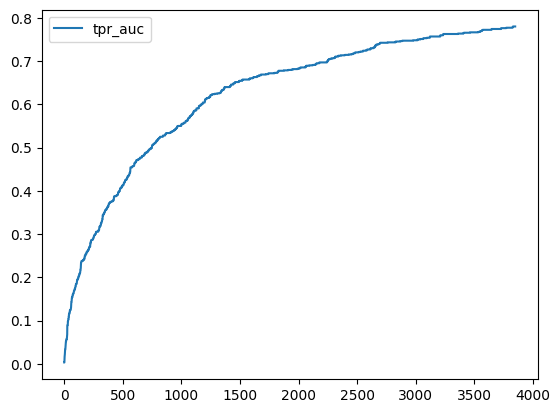

In [13]:
pd.DataFrame(tpr, columns=["tpr_auc"]).plot()